### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

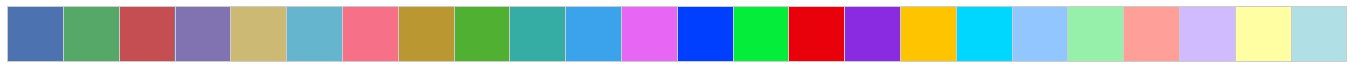

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [2]:
# derivative cols

In [3]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols
train = read_train(used_cols, 100000)
display(train.shape, count_classes(train))

(100000, 48)

(50000, 50000)

Wall time: 195 ms


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [7]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        self.origin_features = [] + xyz_cols #+ mom_cols + hit_type_cols + exy_cols + edxy_cols + dxyz_cols
        features = self.origin_features.copy()

#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        
        filter_data(data)
        
        if not features:
            raise('no features')
    
        self.features = features[len(self.origin_features):]
        return data[features].values

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.728989,0.683159,0.887765,0.772045,0.760788,0.565302,0.099689,0.0
std,0.017568,0.014959,0.022300,0.014706,0.052150,0.389213,0.023003,0.0
min,0.708709,0.666667,0.872093,0.755668,0.707858,0.266707,0.073225,0.0
25%,0.723724,0.676812,0.875000,0.766009,0.735122,0.345208,0.092084,0.0
50%,0.738739,0.686957,0.877907,0.776350,0.762386,0.423710,0.110944,0.0
75%,0.739130,0.691405,0.895601,0.780234,0.787254,0.714600,0.112920,0.0
max,0.739521,0.695853,0.913295,0.784119,0.812121,1.005491,0.114897,0.0


Wall time: 718 ms


### Test theory

In [63]:
%%time
df_scores = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.763910,0.713573,0.881820,0.788817,0.802750,0.760467,0.063731,0.0
std,0.003236,0.004080,0.001524,0.002107,0.005221,0.040677,0.001939,0.0
min,0.758600,0.707212,0.879400,0.785231,0.795512,0.696763,0.060443,0.0
25%,0.764000,0.713075,0.881800,0.789192,0.799986,0.756284,0.063571,0.0
50%,0.764750,0.714529,0.881800,0.789401,0.804262,0.760043,0.064531,0.0
75%,0.764800,0.714587,0.882600,0.789436,0.804682,0.784392,0.064891,0.0
max,0.767400,0.718464,0.883500,0.790827,0.809306,0.804852,0.065221,0.0


Wall time: 1min 41s


### Get result

In [23]:
test = read_pub_test(used_cols)

In [30]:
%%time
fit_predict_save(sample(train, 100000), test, "out/08_cos_mse_nerr_100.csv", n_estimators=120, transformer_cls=DataTransformer)

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Wall time: 25.1 s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [12]:
from transformers.cosine import da_cols

In [27]:
dt = sample(train, 10000)
dt = add_coses(dt, [])
np.arccos(dt[da_cols].quantile(.05)) / np.pi * 180.

DAngle[1]    26.646692
DAngle[2]    36.830097
DAngle[3]    31.931170
Name: 0.05, dtype: float32

In [8]:
def filter_data(data):
    return data

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.723968,0.668741,0.885335,0.761580,0.762366,0.472442,0.086896,0.003430
std,0.029034,0.031701,0.010076,0.018548,0.028124,0.290171,0.041551,0.005941
min,0.706587,0.649123,0.879518,0.748718,0.734725,0.257459,0.054468,0.000000
25%,0.707209,0.650454,0.879518,0.750949,0.748074,0.307412,0.063477,0.000000
50%,0.707831,0.651786,0.879518,0.753181,0.761423,0.357366,0.072486,0.000000
75%,0.732658,0.678550,0.888244,0.768011,0.776186,0.579933,0.103109,0.005145
max,0.757485,0.705314,0.896970,0.782842,0.790950,0.802500,0.133733,0.010290
